## Marcenko-pastur pdf

In [183]:
import numpy as np
import pandas as pd

<AxesSubplot:>

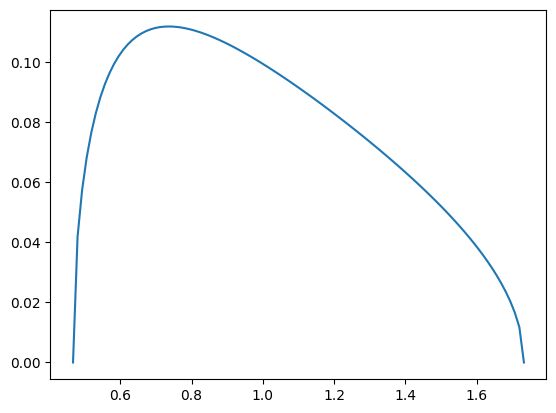

In [184]:
def mp_pdf(var, q, pts):
    """
    Marcenko-Pastur pdf
    q = T/N

    """
    
    e_min, e_max = var*(1 - np.sqrt(1/q))**2, var*(1 + np.sqrt(1/q))**2
    e = np.linspace(e_min, e_max, pts)
    pdf = q/(2*np.pi*var*e)*((e_max - e)*(e - e_min))**0.5

    e = e.reshape(-1)
    pdf = pdf.reshape(-1)
    pdf = pd.Series(pdf, index=e)
    return pdf

mp_pdf(0.1, 0.1, 100).plot()

## Testing the Marcenko pastur theorem

In [185]:
from sklearn.neighbors import KernelDensity

In [186]:
def get_pca(matrix):
    """
    Get the eigenvectors and eigenvalues of a 
    Hermitian matrix. A hermitian matrix is a
    square matrix where the transpose of the matrix
    is equal to the matrix itself. This is true for
    covariance and correlation matrices.

    """
    eigval, eigvec = np.linalg.eigh(matrix)
    indices = eigval.argsort()[::-1]
    eigval, eigvec = eigval[indices], eigvec[:, indices]
    eigval = np.diagflat(eigval)
    return eigval, eigvec

In [187]:
def fit_kde(obs, band_width=25, kernel='gaussian', x=None):
    """
    Fit a kernel density estimator to the observations.
    x is the grid of points to evaluate the kde on.
    
    KDE is a non-parametric way of estimating the probability
    density function of a random variable. It is a flexible
    alternative to histograms and other density estimation methods.
    It has the advantage of not making any assumptions about the
    underlying distribution of the data.
    Although it is a non-parametric method, it does have a
    bandwidth parameter that can be tuned to control the bias-variance
    tradeoff.
    
    The main drawback of KDE is that it is computationally intensive and
    can be slow for large datasets and high dimensional data. In addition,
    it can be unstable for small sample sizes.

    x: grid of points to evaluate the kde on
    """
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    
    kde = KernelDensity(bandwidth=band_width, kernel=kernel)
    kde.fit(obs)

    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    log_prob = kde.score_samples(x)
    pdf = pd.Series(np.exp(log_prob), index=x.flatten())
    return pdf

/tmp/ipykernel_4120/1438333151.py:10: RuntimeWarning: divide by zero encountered in divide
  pdf = q/(2*np.pi*var*e)*((e_max - e)*(e - e_min))**0.5
/tmp/ipykernel_4120/1438333151.py:10: RuntimeWarning: invalid value encountered in multiply
  pdf = q/(2*np.pi*var*e)*((e_max - e)*(e - e_min))**0.5


<AxesSubplot:>

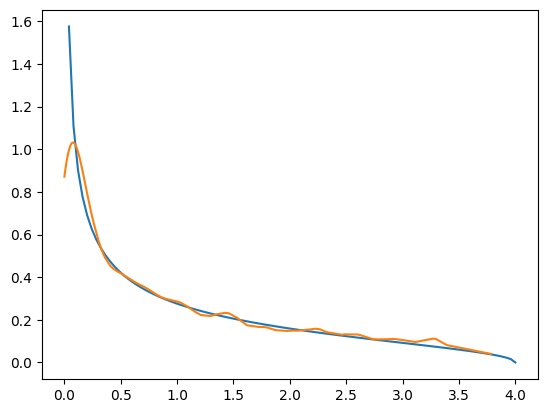

In [188]:
x = np.random.normal(size=(100, 100))
eigval, eigvec = get_pca(np.corrcoef(x, rowvar=False))

pdf0 = mp_pdf(1, 1000/1000, 100)
pdf1 = fit_kde(eigval.diagonal(), band_width=0.1)

pdf0.plot()
pdf1.plot()

## Random matrix with signal

In [189]:
def get_rnd_conv(n_cols, n_facts):
    """
    Get a random matrix with a given number of factors.
    """
    w = np.random.normal(size=(n_cols, n_facts))
    cov = np.dot(w, w.T)
    cov += np.diag(np.random.uniform(size=n_cols))
    return cov

In [190]:
def cov2corr(cov):
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1
    return corr
    

In [191]:
alpha, n_cols, n_facts, q = .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(n_cols*q, n_cols)), rowvar=False)

cov = alpha * cov + (1 - alpha) * get_rnd_conv(n_cols, n_facts)
corr0 = cov2corr(cov)

eigval0, eigvec0 = get_pca(corr0)

## Fitting a marcenko-pastur pdf

In [207]:
from scipy.optimize import minimize

def error_pdfs(var, eigval, q, bwidth, pts=1000):
    
    pdf0 = mp_pdf(var, q, pts)
    
    pdf1 = fit_kde(eigval.diagonal(), band_width=bwidth, x=pdf0.index.values.reshape(-1))

    sse = np.sum((pdf0 - pdf1)**2)
    return sse

def find_max_eval(eigval, q, bwidth):
    """
    Find the maximum eigenvalue of the covariance matrix
    using the Marcenko-Pastur pdf.
    """
    out = minimize(lambda *x: error_pdfs(*x), 1, args=(eigval, q, bwidth),
        bounds=((1e-5, 1-1e-5),))
    print(out)
    if out["success"]:
        var = out["x"][0]
    else: var = 1

    e_max =  var*(1 + np.sqrt(1/q))**2
    print(var)
    return e_max, var

e_max, var = find_max_eval(eigval0, 10, 0.01)

n_facts0 = eigval0.shape[0] - np.diag(eigval0)[::-1].searchsorted(e_max)

      fun: 18.187535813595595
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.81597005e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([0.6777218])
0.6777218024327054


In [208]:
n_facts0

100

<AxesSubplot:>

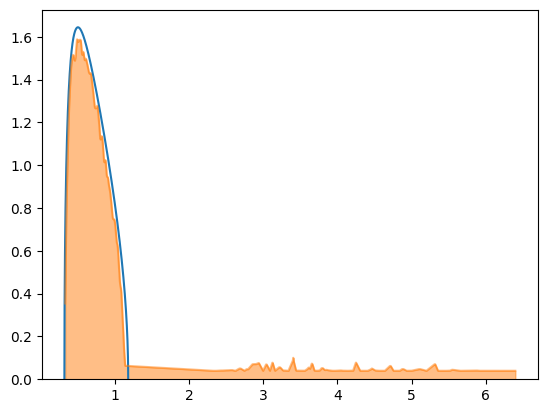

In [209]:
pm_pdf = mp_pdf(0.68, 10, 1000).plot()
fit_kde(eigval0.diagonal(), band_width=0.01).plot(kind='area', alpha=0.5)

In [210]:
eigval0.shape

(1000, 1000)

In [211]:
def m_p_pdf(var, q, pts):
    emin, emax = var * (1 - np.sqrt(1/q))**2, var * (1 + np.sqrt(1/q))**2

### Constant residual eigenvalue method
Setting a constant eigenvalue for all random eigenvectors

In [212]:
def denoise_cre(e_val, e_vect, n_facts):
    """
    Denoise a correlation matrix by fixing random eigenvalues.
    constant residual eigenvalue method
    
    Args:
        e_val: eigenvalues
        e_vect: eigenvectors
        n_facts: number of factors to keep
    
    """

    e_val_ = np.diag(e_val).copy()
    e_val_[n_facts:] = e_val_[n_facts:].mean()
    e_val_ = np.diag(e_val_)
    corr = np.dot(e_vect, np.dot(e_val_, e_vect.T))
    corr = cov2corr(corr)
    return corr



In [213]:
n_facts0
eigvec0
pass

In [214]:
corr1 = denoise_cre(eigval0, eigvec0, n_facts0)
eval1, evec1 = get_pca(corr1)


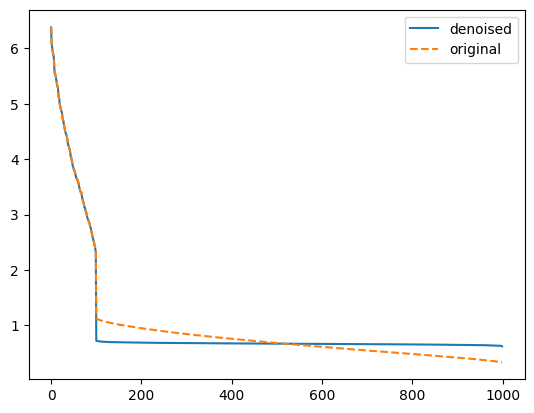

In [218]:
import matplotlib.pyplot as plt

plt.plot(np.diag(eval1), label='denoised')
plt.plot(np.diag(eigval0), linestyle='--', label='original')
plt.legend()
plt.show()

### Targeted Shrinkage

Applies a shrinkage factor to the random part of the correlation matrix

In [219]:
def denoise_target_shrinkage(e_val, e_vect, n_facts, alpha=0):
    """
    Removes noise from corr through targeted shrinkage
    The process of targeted shrinkage for denoising correlation 
    matrices involves estimating the noise level in the matrix and
     then shrinking the elements of the matrix towards the average 
     or diagonal element based on the estimated noise level. 
     The degree of shrinkage is proportional to the magnitude of the
      elements, and the shrinkage threshold is adjusted based on the estimated noise level. 
    """

    eval, evect, = e_val[:n_facts, :n_facts], e_vect[:, :n_facts] # signal
    evalr, evectr = e_val[n_facts:, n_facts:], e_vect[:, n_facts:] # noise
    corr0 = np.dot(evect, np.dot(eval, evect.T)) # signal
    corr1 = np.dot(evectr, np.dot(evalr, evectr.T)) # noise

    corr2 = corr0 + alpha * corr1 + (1 - alpha) * np.diag(np.diag(corr0))

    return corr2


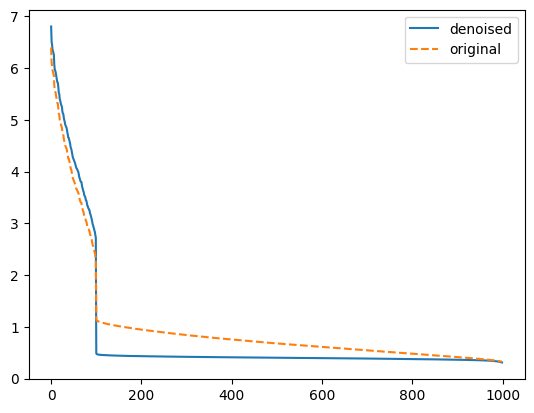

In [222]:
corr1 = denoise_target_shrinkage(eigval0, eigvec0, n_facts0, alpha=0)
eval1, evec1 = get_pca(corr1)

plt.plot(np.diag(eval1), label='denoised')
plt.plot(np.diag(eigval0), linestyle='--', label='original')
plt.legend()
plt.show()

## Detoning

Involves removing the market component of the financial correlation matrices. Detoning is the principal components analysis anologue to computing beta-adjusted or market-adjusted returns in regression analysis.

* We can remove the market component from the denoised correlation matrix to form the detoned correlation matrix

c2_hat = c1 - W_mD_mW^t_m = W_dD_dW^t_d


The detoned corr matrix is singula (a problem for clustering wich requires invertivility of the corr matrix)

The denoted corr matrix can not be used directly for mean-variance portfolio optimization, instead, we can optimize a portfolio on the selected nonzero principal components, and map the optimzal allocations f* tii the original basis: w* = W_{+} f*